<a href="https://colab.research.google.com/github/mqanaq/BA820-B1-Team13/blob/main/Danish_Azmi/M2_Assignment_Danish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploratory Data Analysis For Fair Use Cases Data**

**BA820 - Project Milestone 2

**Team:** B1 Team 13

**Team Members:** Danish Azmi

# Introduction

This project uses a public dataset of U.S. fair use decisions from the U.S. Copyright Office Fair Use Index. Each record summarizes a case and includes structured attributes such as court, jurisdiction, year, and content categories, plus text fields that describe the facts, legal issue, and holding. The dataset also includes an outcome indicator showing whether fair use was found.

The notebook aims to move beyond the basic data preperation and exploratory analysis surface patterns specifically a question that emerged during the inital proposal Scenario bundles that define most disputes Question: What tag/category combinations repeatedly appear as common “scenario bundles,” and do these bundles correspond to distinct dispute themes in the summaries (e.g., licensing breakdowns, ownership ambiguity, takedowns) or mainly reflect metadata like venue? Why worth answering / decision use: Reveals the dominant dispute archetypes so organizations can prioritize the highest-impact scenarios with playbooks, contract templates, training, or product/policy changes.

# Setting Up

In [3]:
# supressing some unimportant warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as shc
from sklearn.metrics.pairwise import cosine_similarity
sns.set_style("whitegrid")
import networkx as nx


# Data Importing, Inspection and Preparation

## Data Importing

In [4]:
fair_use_cases = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-08-29/fair_use_cases.csv')
fair_use_findings = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-08-29/fair_use_findings.csv')

## Data Inspection

### Fair Use Cases Table

The `fair_use_cases` table provides one row per case with structured metadata such as year, court, jurisdiction, content categories, and a binary indicator for whether fair use was found. Inspection focuses on confirming completeness, consistency of categorical fields, and suitability for comparing outcomes across courts, categories, and time.

| variable       | class     | description                                                                                                   |
| -------------- | --------- | ------------------------------------------------------------------------------------------------------------- |
| case           | character | The name and number of the case.                                                                              |
| year           | integer   | The year in which the case was decided.                                                                       |
| court          | character | The court in which the ruling was made.                                                                       |
| jurisdiction   | character | The jurisdiction of that court.                                                                               |
| categories     | character | A comma- or semicolon-separated list of categories to which the case belongs. These have not been normalized. |
| outcome        | character | A string describing the outcome of the case.                                                                  |
| fair_use_found | logical   | Whether fair use was found by the court. FALSE might sometimes indicate a more complicated finding.           |

In [5]:
print("Dataset Info:")
print(fair_use_cases.info())

print("\nFirst 5 rows:")
print(fair_use_cases.head())

print("\nMissing Values:")
print(fair_use_cases.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   case            251 non-null    object
 1   year            251 non-null    int64 
 2   court           251 non-null    object
 3   jurisdiction    251 non-null    object
 4   categories      251 non-null    object
 5   outcome         251 non-null    object
 6   fair_use_found  251 non-null    bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 12.1+ KB
None

First 5 rows:
                                                case  year        court  \
0  De Fontbrune v. Wofsy, 39 F.4th 1214 (9th Cir....  2022  9th Circuit   
1  Sedlik v. Von Drachenberg, No. CV 21-1102 (C.D...  2022    C.D. Cal.   
2  Sketchworks Indus. Strength Comedy, Inc. v. Ja...  2022     S.D.N.Y.   
3  Am. Soc'y for Testing & Materials v. Public.Re...  2022       D.D.C.   
4  Yang v. Mic Network Inc., No

### Fair Use Findings Table

The `fair_use_findings` table contains complementary case-level text, including summaries of key facts, legal issues, holdings, and descriptive tags. Inspection centers on text completeness and variability, as these fields support later analysis of language patterns, similarity, and thematic structure across cases.

| variable    | class     | description                                                                            |
| ----------- | --------- | -------------------------------------------------------------------------------------- |
| title       | character | The title of the case.                                                                 |
| case_number | character | The case number or numbers of the case.                                                |
| year        | character | The year in which the finding was made (or findings were made).                        |
| court       | character | The court or courts involved.                                                          |
| key_facts   | character | The key facts of the case.                                                             |
| issue       | character | A brief description of the fair use issue.                                             |
| holding     | character | The decision of the court in paragraph form.                                           |
| tags        | character | Comma- or semicolon-separated tags for this case.                                      |
| outcome     | character | A brief description of the outcome of the case. These fields have not been normalized. |

In [6]:
print("Dataset Info:")
print(fair_use_findings.info())

print("\nFirst 5 rows:")
print(fair_use_findings.head())

print("\nMissing Values:")
print(fair_use_findings.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        251 non-null    object
 1   case_number  251 non-null    object
 2   year         251 non-null    object
 3   court        251 non-null    object
 4   key_facts    251 non-null    object
 5   issue        251 non-null    object
 6   holding      251 non-null    object
 7   tags         251 non-null    object
 8   outcome      251 non-null    object
dtypes: object(9)
memory usage: 17.8+ KB
None

First 5 rows:
                                               title  \
0                              De Fontbrune v. Wofsy   
1                          Sedlik v. Von Drachenberg   
2  Sketchworks Indus. Strength Comedy, Inc. v. Ja...   
3  Am. Soc'y for Testing & Materials v. Public.Re...   
4                           Yang v. Mic Network Inc.   

                                 

## Preparing Data

An attempt to merge the two tables was made but in practice, many rows do not join because the identifiers are not standardized. For example, `case_number` in the findings table often includes extra citation text (like Westlaw or LEXIS), and case names can differ in punctuation or abbreviations (for example “v.” vs “vs”, “Inc.” vs “Inc”). Fixing this reliably usually needs record linkage methods such as fuzzy matching or NLP-based similarity. Because of that, the EDA treats the two tables separately, and a more advanced merge can be added later if a single combined table is required.

# Exploratory Data Analysis (EDA)

This EDA looks at the two tables as they are: `fair_use_cases` contains structured metadata (year, court, jurisdiction, categories, outcome, fair_use_found) and `fair_use_findings` adds narrative text (key_facts, issue, holding) plus tags. Because the identifiers do not merge reliably with simple string matching, the exploration is done separately, using tables plus plots to summarize the main patterns.

## Part 1: Outcome Profile and Historical Shifts

This section checks the overall balance of outcomes and whether the fair use finding rate changes over time, which can hint at shifts in how cases are decided or what kinds of cases appear in different periods.

In [7]:
fair_use_cases["fair_use_found"].value_counts(dropna=False).to_frame("count")

,count
fair_use_found,
False,150
True,101


Most cases end with fair use not found (150) compared with fair use found (101), so the outcome variable is somewhat imbalanced and later comparisons should keep that baseline in mind.

In [8]:
by_year = (fair_use_cases.groupby("year")
           .agg(n_cases=("fair_use_found", "size"),
                fair_use_found_rate=("fair_use_found", "mean"))
           .reset_index())

by_year

,year,n_cases,fair_use_found_rate
0,1841,1,0.000000
1,1950,1,0.000000
2,1956,1,0.000000
3,1957,1,1.000000
4,1962,1,0.000000
5,1964,1,1.000000
6,1966,1,0.000000
7,1973,1,1.000000
8,1976,1,0.000000
9,1977,2,0.500000


The fair use rate varies a lot across years, with many years showing extreme values like 0.0 or 1.0, which strongly suggests small sample sizes per year and makes single-year rates noisy.

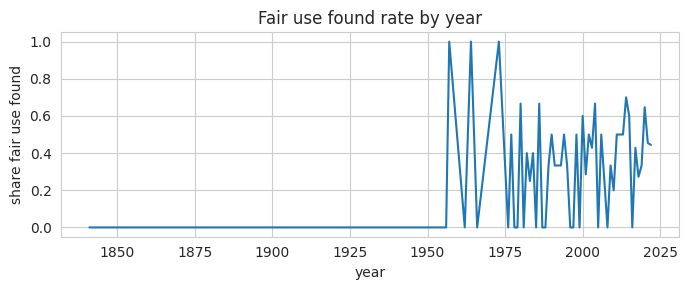

In [ ]:
plt.figure(figsize=(7,3))
plt.plot(by_year["year"], by_year["fair_use_found_rate"])
plt.title("Fair use found rate by year")
plt.xlabel("year")
plt.ylabel("share fair use found")
plt.tight_layout()
plt.show()

The chart visualizes the same pattern: early years have sharp spikes because there are few observations, while later years show frequent ups and downs but generally sit in a mid-range band rather than staying consistently high or low.

## Part 2: Decision Venue Footprint

This section summarizes which courts and jurisdictions appear most often, since concentration in a few courts can shape the overall patterns and may reveal places where outcomes differ.

In [ ]:
fair_use_cases["court"].value_counts().head(10).to_frame("count")

,count
court,
S.D.N.Y.,47
2d Circuit,45
9th Circuit,34
C.D. Cal.,17
11th Circuit,8
4th Circuit,7
7th Circuit,7
D. Nev.,5
U.S. Supreme Court,5


Cases are concentrated in a few courts, led by S.D.N.Y. (47), 2d Circuit (45), and 9th Circuit (34), with a noticeable drop after the top three.

In [ ]:
fair_use_cases["jurisdiction"].value_counts().head(10).to_frame("count")

,count
jurisdiction,
2nd Circuit,98
9th Circuit,64
11th Circuit,13
7th Circuit,12
4th Circuit,11
5th Circuit,10
1st Circuit,9
6th Circuit,9
3rd Circuit,8


Jurisdiction is even more concentrated, with the 2nd Circuit (98) and 9th Circuit (64) making up a large share of the dataset, so overall patterns may largely reflect those regions.

In [ ]:
top_courts = fair_use_cases["court"].value_counts().head(10).reset_index()
top_courts.columns = ["court", "count"]
top_courts

,court,count
0,S.D.N.Y.,47
1,2d Circuit,45
2,9th Circuit,34
3,C.D. Cal.,17
4,11th Circuit,8
5,4th Circuit,7
6,7th Circuit,7
7,D. Nev.,5
8,U.S. Supreme Court,5
9,5th Circuit,5


This output matches the earlier court ranking and mainly confirms the ordering used to generate the chart.

<Figure size 700x300 with 0 Axes>

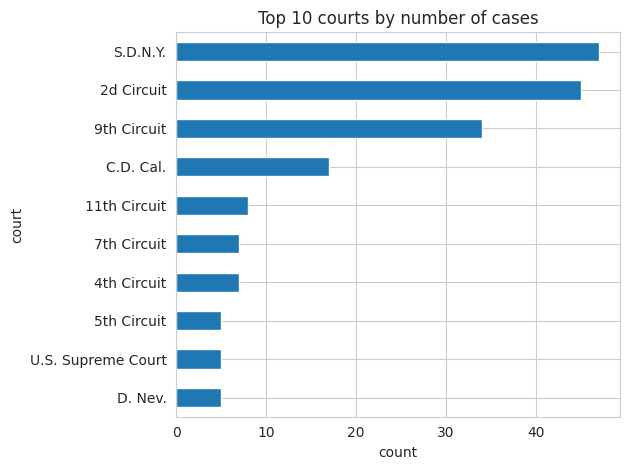

In [ ]:
plt.figure(figsize=(7,3))
top_courts.sort_values("count").plot(kind="barh", x="court", y="count", legend=False)
plt.title("Top 10 courts by number of cases")
plt.xlabel("count")
plt.ylabel("court")
plt.tight_layout()
plt.show()

The chart makes the imbalance clear: after the top three, counts fall quickly, so comparisons involving smaller courts will be less reliable due to low sample sizes.

## Part 3: Case Segment Mix and Label Co-occurrence

This section looks at how cases are labeled in each table. `categories` in the cases table and `tags` in the findings table help describe what kinds of works or issues appear most, what is rare, and what areas may be worth deeper investigation.

In [ ]:
cats = (fair_use_cases[["case", "fair_use_found", "categories"]]
        .dropna(subset=["categories"])
        .assign(category=fair_use_cases["categories"].astype(str).str.split(r",|;"))
        .explode("category"))

cats["category"] = cats["category"].astype(str).str.strip().str.lower()

top_categories = cats["category"].value_counts().head(15).reset_index()
top_categories.columns = ["category", "count"]
top_categories

,category,count
0,textual work,94
1,film/audiovisual,65
2,photograph,63
3,education/scholarship/research,56
4,internet/digitization,51
5,review/commentary,46
6,news reporting,38
7,parody/satire,34
8,painting/drawing/graphic,31
9,music,27


The dataset is dominated by a few content types, especially Textual work (84), Film/Audiovisual (64), and Photograph (63), with a gradual drop after the top group. This suggests EDA and later analysis should focus on these “high-volume” categories first, since they drive most of the signal.

<Figure size 700x300 with 0 Axes>

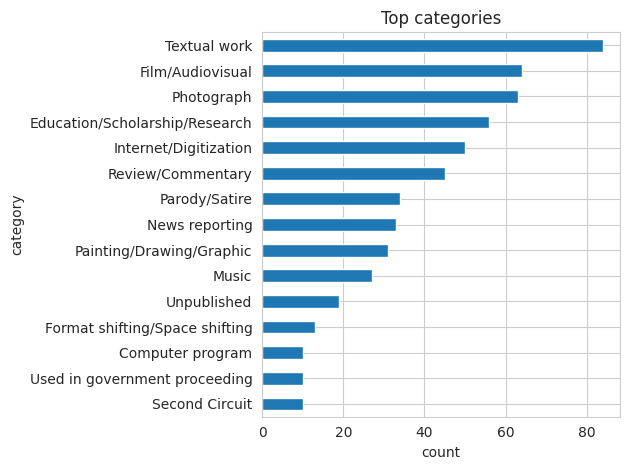

In [ ]:
plt.figure(figsize=(7,3))
top_categories.sort_values("count").plot(kind="barh", x="category", y="count", legend=False)
plt.title("Top categories")
plt.xlabel("count")
plt.ylabel("category")
plt.tight_layout()
plt.show()

The chart makes the long-tail pattern clearer: a small set of categories accounts for a large share of cases, while many categories appear relatively rarely, which can make category-level comparisons noisy for smaller groups.

In [ ]:
tags = (fair_use_findings[["title", "tags"]]
        .dropna(subset=["tags"])
        .assign(tag=fair_use_findings["tags"].astype(str).str.split(r",|;"))
        .explode("tag"))

tags["tag"] = tags["tag"].astype(str).str.strip().str.lower()

top_tags = tags["tag"].value_counts().head(15).reset_index()
top_tags.columns = ["tag", "count"]
top_tags

,tag,count
0,textual work,95
1,second circuit,79
2,film/audiovisual,65
3,photograph,64
4,education/scholarship/research,57
5,ninth circuit,55
6,internet/digitization,51
7,review/commentary,46
8,news reporting,39
9,parody/satire,34


The tag list overlaps heavily with categories (Textual work, Film/Audiovisual, Photograph), but it also includes court-related tags like Second Circuit (79) and Ninth Circuit (55). That implies tags mix “case type” information with “where the case was decided,” so tags may not be purely topical.

<Figure size 700x300 with 0 Axes>

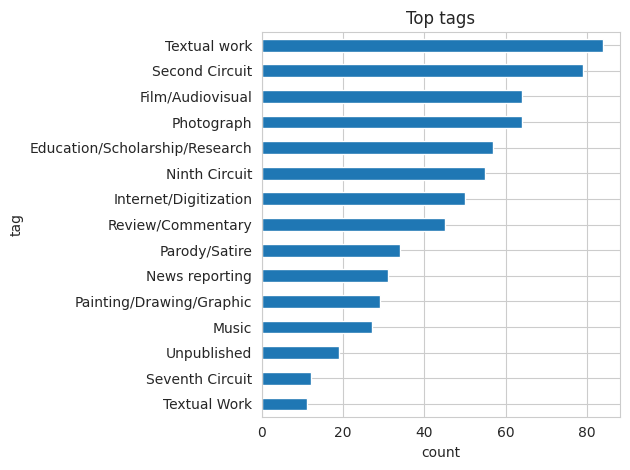

In [ ]:
plt.figure(figsize=(7,3))
top_tags.sort_values("count").plot(kind="barh", x="tag", y="count", legend=False)
plt.title("Top tags")
plt.xlabel("count")
plt.ylabel("tag")
plt.tight_layout()
plt.show()


The plot reinforces two points: most tags mirror the main content categories, and court-related tags are among the most frequent. Also, a small data-quality detail shows up: Textual work and Textual Work appear separately, which indicates inconsistent capitalization and a need to standardize labels before deeper tag-based analysis.

## Part 4: Narrative Detail and Text Complexity

Finally, inspect how long the case narratives are and how much they vary, since large differences in length can signal different types of cases or levels of detail.

In [ ]:
text_cols = ["key_facts", "issue", "holding"]
for c in text_cols:
    fair_use_findings[c] = fair_use_findings[c].astype(str)
    fair_use_findings[c + "_words"] = fair_use_findings[c].str.split().str.len()

fair_use_findings[[c + "_words" for c in text_cols]].describe()


,key_facts_words,issue_words,holding_words
count,251.000000,251.000000,251.000000
mean,122.195219,22.434263,197.382470
std,50.487441,8.928531,101.760961
min,33.000000,10.000000,4.000000
25%,84.500000,17.000000,121.000000
50%,111.000000,21.000000,173.000000
75%,149.500000,26.000000,269.500000
max,344.000000,109.000000,744.000000


The narrative fields vary a lot in length. On average, key_facts are about 122 words (33 to 344), issue is much shorter at about 22 words (10 to 109), and holding is the longest at about 197 words with a very wide range (4 to 744). The large standard deviation for holdings suggests some cases have extremely detailed writeups compared to others.

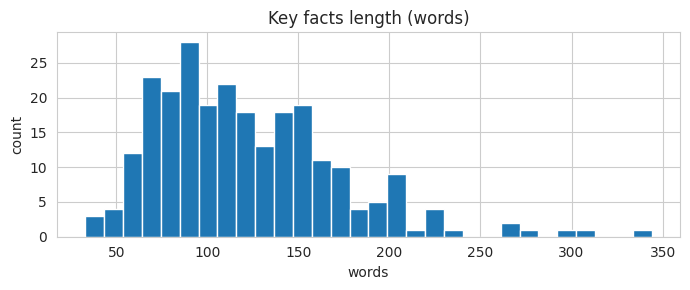

In [ ]:
plt.figure(figsize=(7,3))
plt.hist(fair_use_findings["key_facts_words"], bins=30)
plt.title("Key facts length (words)")
plt.xlabel("words")
plt.ylabel("count")
plt.tight_layout()
plt.show()


The key facts length is concentrated in a mid-range (roughly around 70 to 160 words), with a clear right tail showing a smaller number of much longer summaries. That tail matters later because longer texts can dominate similarity or clustering methods if length is not controlled.

In [ ]:
fair_use_findings[["title", "key_facts_words"]].nlargest(5, "key_facts_words")

,title,key_facts_words
66,Corbello v. DeVito,344
74,Cambridge University Press v. Mark P. Becker,309
16,"Google LLC v. Oracle Am., Inc.",297
65,"Donald Graham v. Richard Prince, et al.",272
62,"Disney Enterprises, Inc. v. VidAngel, Inc.",267


These cases have the most detailed “key facts” summaries, which signals higher narrative complexity and likely more moving parts in the dispute. They are useful stress tests for later text analysis because their length can dominate similarity measures or clustering if text length is not normalized.

In [ ]:
fair_use_findings[["title", "holding_words"]].nlargest(5, "holding_words")

,title,holding_words
3,Am. Soc'y for Testing & Materials v. Public.Re...,744
16,"Google LLC v. Oracle Am., Inc.",734
86,"Cambridge Univ. Press v. Patton,",548
60,"Penguin Random House LLC, et al. v. Frederik C...",454
72,"TCA Television Corp. v. McCollum,",381


These cases contain the most extensive holdings, suggesting especially complex legal reasoning or multi-issue decisions. They highlight clear “extreme cases” in the dataset and should be reviewed when interpreting text-based models, since very long holdings can disproportionately influence themes and embeddings.

In [ ]:
stop = {"the","and","to","of","a","in","for","on","with","as","by","at","from","an","or","is","was","are","be","that","this"}

words = (fair_use_findings["holding"].astype(str).str.lower()
         .str.replace(r"[^a-z\s]", " ", regex=True)
         .str.split()
         .explode())

words = words[~words.isin(stop) & words.str.len().ge(3)]

top_words = words.value_counts().head(20).reset_index()
top_words.columns = ["word", "count"]
top_words

,word,count
0,use,1520
1,court,1358
2,fair,815
3,not,608
4,work,543
5,found,487
6,factor,466
7,because,401
8,market,366
9,defendant,353


The most frequent terms are strongly legal and decision-focused (for example, use, court, fair, factor, market, defendant), which confirms the holdings are written in consistent judicial language. This also suggests that later NLP steps should filter generic legal boilerplate (and possibly combine singular/plural forms like defendant/defendants and work/works) to better surface content-specific themes.

#M2 - Initial analysis and Association rules

To initiate an inquery into the question we need to acknowledge the initial finding that the tags/categories with minimal frequency might just add to noise, to simplify and counteract this, clubbing the tag/categories with less then 20 into one other category


In [9]:
import pandas as pd


fair_use_findings['tags_list'] = fair_use_findings['tags'].str.split(';')
df_exploded = fair_use_findings.explode('tags_list')

df_exploded['tags_list'] = df_exploded['tags_list'].str.strip()

df_unique = df_exploded.drop_duplicates(subset=['case_number', 'tags_list'])
df_matrix = pd.crosstab(df_unique['case_number'], df_unique['tags_list'])
print("\nFinal Matrix Shape:", df_matrix.shape)
print(df_matrix.head())


Final Matrix Shape: (251, 59)
tags_list                                           Computer Program  \
case_number                                                            
108 F.3d 1119 (9th Cir. 1997), cert. denied 522...                 0   
109 F.3d 1394 (9th Cir. 1997)                                      0   
11 F. Supp. 2d 1179 (C.D. Cal. 1998)                               0   
126 F.3d 70 (2d Cir. 1997)                                         0   
132 F. Supp. 2d 229 (S.D.N.Y. 2001)                                0   

tags_list                                           Computer program  \
case_number                                                            
108 F.3d 1119 (9th Cir. 1997), cert. denied 522...                 0   
109 F.3d 1394 (9th Cir. 1997)                                      0   
11 F. Supp. 2d 1179 (C.D. Cal. 1998)                               0   
126 F.3d 70 (2d Cir. 1997)                                         0   
132 F. Supp. 2d 229 (S.D.N.Y. 20

Convert the data into an encoded format

In [10]:
frequent_itemsets = apriori(df_matrix, min_support=0.005, use_colnames=True)
frequent_itemsets.sort_values(by="support")

,support,itemsets
19,0.007968,"(Ninth Circuit, Photograph, Review/Commentary)"
28,0.007968,(Tenth Circuit)
272,0.007968,"(Painting/Drawing/Graphic, Second Circuit, Tex..."
275,0.007968,"(Review/Commentary, Parody/Satire, Second Circ..."
277,0.007968,"(Review/Commentary, Photograph, Sculpture)"
...,...,...
22,0.223108,(Photograph)
3,0.227092,(Education/Scholarship/Research)
9,0.239044,(Film/Audiovisual)
25,0.286853,(Second Circuit)


In [11]:
rules = association_rules(frequent_itemsets,
                          num_itemsets=frequent_itemsets.shape[0],
                          metric="confidence", min_threshold=0.4) #, metric="support", min_threshold=0.05
rules.sort_values(by=["support", "confidence"])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
42,"(Education/Scholarship/Research, Eleventh Circ...",(Internet/Digitization),0.019920,0.159363,0.007968,0.400000,2.510000,1.0,0.004794,1.401062,0.613821,0.046512,0.286256,0.225000
44,"(Education/Scholarship/Research, Eleventh Circ...",(Review/Commentary),0.019920,0.155378,0.007968,0.400000,2.574359,1.0,0.004873,1.407703,0.623984,0.047619,0.289623,0.225641
62,"(Music, Ninth Circuit)",(Education/Scholarship/Research),0.019920,0.227092,0.007968,0.400000,1.761404,1.0,0.003444,1.288181,0.441057,0.033333,0.223711,0.217544
99,"(Textual work, Eleventh Circuit)",(Internet/Digitization),0.019920,0.159363,0.007968,0.400000,2.510000,1.0,0.004794,1.401062,0.613821,0.046512,0.286256,0.225000
101,"(Textual work, Eleventh Circuit)",(Parody/Satire),0.019920,0.135458,0.007968,0.400000,2.952941,1.0,0.005270,1.440903,0.674797,0.054054,0.305991,0.229412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,(Internet/Digitization),(Photograph),0.159363,0.223108,0.063745,0.400000,1.792857,1.0,0.028190,1.294821,0.526066,0.200000,0.227692,0.342857
30,(Review/Commentary),(Second Circuit),0.155378,0.286853,0.075697,0.487179,1.698362,1.0,0.031126,1.390637,0.486842,0.206522,0.280905,0.375534
32,(Second Circuit),(Textual work),0.286853,0.330677,0.115538,0.402778,1.218039,1.0,0.020682,1.120726,0.251011,0.230159,0.107722,0.376088
8,(Textual work),(Education/Scholarship/Research),0.330677,0.227092,0.143426,0.433735,1.909956,1.0,0.068332,1.364923,0.711806,0.346154,0.267358,0.532657


In [29]:
rules_filtered = rules[(rules['confidence'] > 0.5) & (rules['lift'] >= 1.5)]
rules_filtered.sort_values(by=["confidence", "lift"], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
240,"(Internet/Digitization, Film/Audiovisual, Nint...",(Format shifting/Space Shifting),0.007968,0.007968,0.007968,1.000000,125.500000,1.0,0.007905,inf,1.000000,1.000000,1.000000,1.000000
248,(Format shifting/Space Shifting),"(Internet/Digitization, Film/Audiovisual, Nint...",0.007968,0.007968,0.007968,1.000000,125.500000,1.0,0.007905,inf,1.000000,1.000000,1.000000,1.000000
295,"(Music, Photograph)","(Education/Scholarship/Research, Film/Audiovis...",0.007968,0.011952,0.007968,1.000000,83.666667,1.0,0.007873,inf,0.995984,0.666667,1.000000,0.833333
97,(Educational/Scholarship/Research),"(Internet/Digitization, Textual Work)",0.007968,0.015936,0.007968,1.000000,62.750000,1.0,0.007841,inf,0.991968,0.500000,1.000000,0.750000
105,(Format shifting/Space Shifting),"(Internet/Digitization, Film/Audiovisual)",0.007968,0.015936,0.007968,1.000000,62.750000,1.0,0.007841,inf,0.991968,0.500000,1.000000,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,(Sixth Circuit),(Textual work),0.027888,0.330677,0.015936,0.571429,1.728055,1.0,0.006714,1.561753,0.433402,0.046512,0.359694,0.309811
65,"(Education/Scholarship/Research, Ninth Circuit)",(Textual work),0.027888,0.330677,0.015936,0.571429,1.728055,1.0,0.006714,1.561753,0.433402,0.046512,0.359694,0.309811
3,(Eleventh Circuit),(Education/Scholarship/Research),0.035857,0.227092,0.019920,0.555556,2.446394,1.0,0.011778,1.739044,0.613223,0.081967,0.424971,0.321637
13,(Eleventh Circuit),(Textual work),0.035857,0.330677,0.019920,0.555556,1.680054,1.0,0.008063,1.505976,0.419835,0.057471,0.335979,0.307898


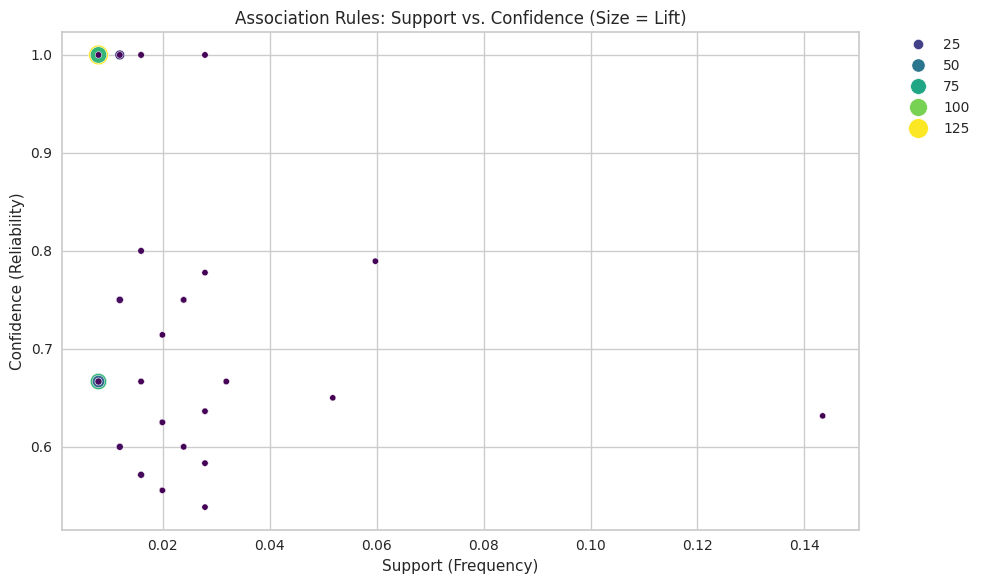

In [34]:
plt.figure(figsize=(10, 6))
sc = sns.scatterplot(
    data=rules_filtered,
    x="support",
    y="confidence",
    size="lift",
    hue="lift",
    palette="viridis",
    sizes=(20, 200),
    legend="brief"
)

plt.title("Association Rules: Support vs. Confidence (Size = Lift)")
plt.xlabel("Support (Frequency)")
plt.ylabel("Confidence (Reliability)")
# Move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

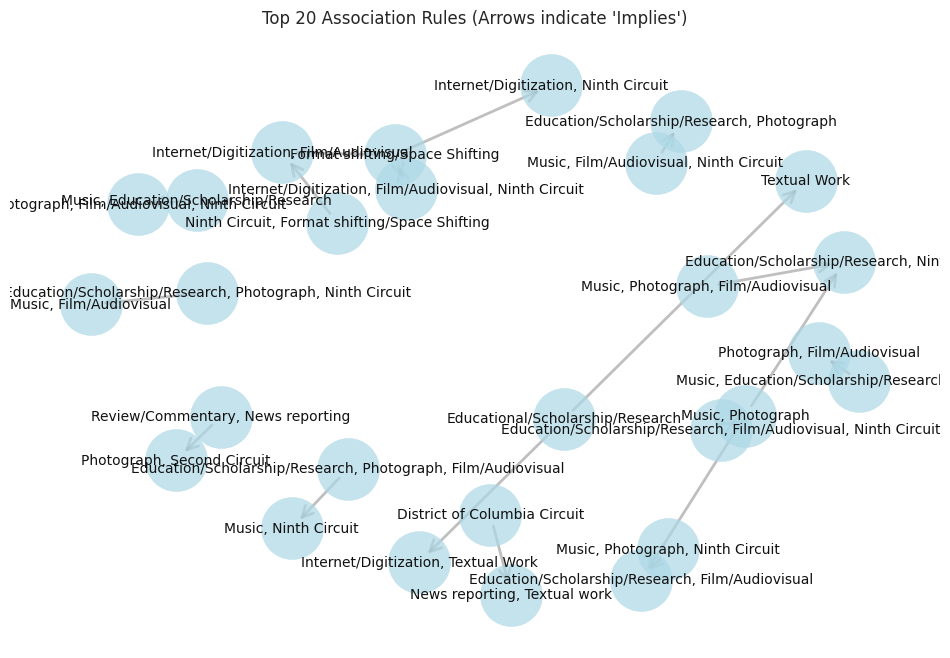

In [35]:
G = nx.DiGraph() # Directed Graph because rules go A -> B

top_rules = rules_filtered.sort_values('lift', ascending=False).head(20)

for i, row in top_rules.iterrows():
    # Convert frozensets to strings
    ant = ", ".join(list(row['antecedents']))
    con = ", ".join(list(row['consequents']))

    G.add_edge(ant, con, weight=row['lift'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1)

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', alpha=0.7)

nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='gray', arrowstyle='->', arrowsize=20)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.title("Top 20 Association Rules (Arrows indicate 'Implies')")
plt.axis('off')
plt.show()

#Kmeans
To answer the second part of the question "...do these bundles correspond to distinct dispute themes in the summaries... or mainly reflect metadata?" we utilize kmeans using TF_IDF vectorizing

Running Elbow Method on rich text data...


/usr/local/lib/python3.12/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.12/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


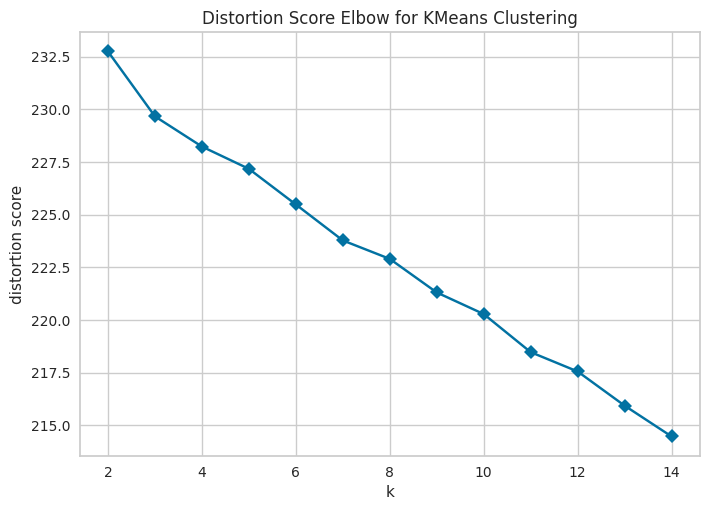

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.cluster import KElbowVisualizer

fair_use_findings['full_text'] = (fair_use_findings['key_facts'].fillna('') + " " +
                                  fair_use_findings['issue'].fillna('') + " " +
                                  fair_use_findings['holding'].fillna(''))

tfidf = TfidfVectorizer(max_features=5000,
                        stop_words='english',
                        ngram_range=(1,2))

text_matrix = tfidf.fit_transform(fair_use_findings['full_text'])
print("Running Elbow Method on rich text data...")

model = KMeans(random_state=42, n_init=10)

visualizer = KElbowVisualizer(
    model,
    k=(2, 15),           # Check from 2 to 15 clusters
    metric='distortion', # 'distortion' is standard
    timings=False
)

visualizer.fit(text_matrix.toarray())
visualizer.show()

Elbow is not really visible, clusters are too similar so will have to try something else try to remove legal fluff

Running Silhouette Analysis...


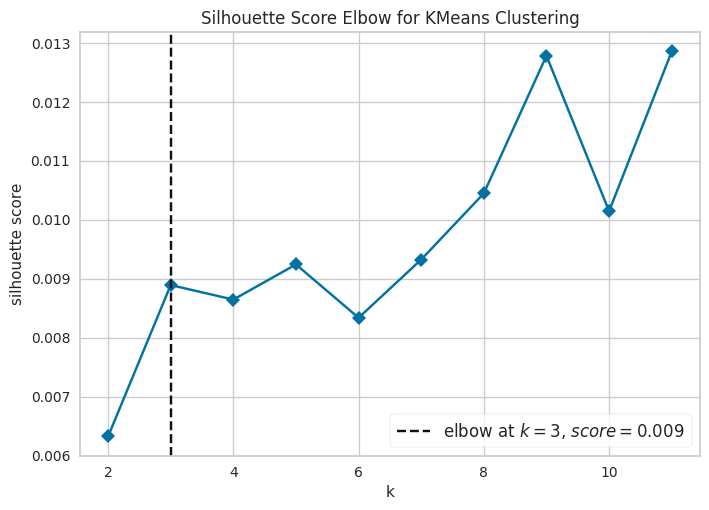

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [14]:
# 1. Define "Legal Fluff" to ignore
#    If we don't remove these, every cluster looks identical.
my_stop_words = [
    'court', 'case', 'copyright', 'fair', 'use', 'plaintiff', 'defendant',
    'judge', 'district', 'appeal', 'circuit', 'infringement', 'holding',
    'fact', 'issue', 'summary', 'judgment', 'claimed', 'argued'
]

# 2. Vectorize with Custom Stop Words
#    We combine the standard English list with our custom legal list
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
all_stop_words = list(ENGLISH_STOP_WORDS) + my_stop_words

tfidf = TfidfVectorizer(max_features=3000,
                        stop_words=all_stop_words, # <--- The key change
                        ngram_range=(1,2))

text_matrix = tfidf.fit_transform(fair_use_findings['full_text'])

# 3. Run Visualizer with "Silhouette" Metric
#    Silhouette Score is often sharper for text data than Distortion
print("Running Silhouette Analysis...")

model = KMeans(random_state=42, n_init=10)

visualizer = KElbowVisualizer(
    model,
    k=(2, 12),
    metric='silhouette',  # <--- Change metric to see if a peak appears
    timings=False
)

visualizer.fit(text_matrix.toarray())
visualizer.show()

/usr/local/lib/python3.12/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.12/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


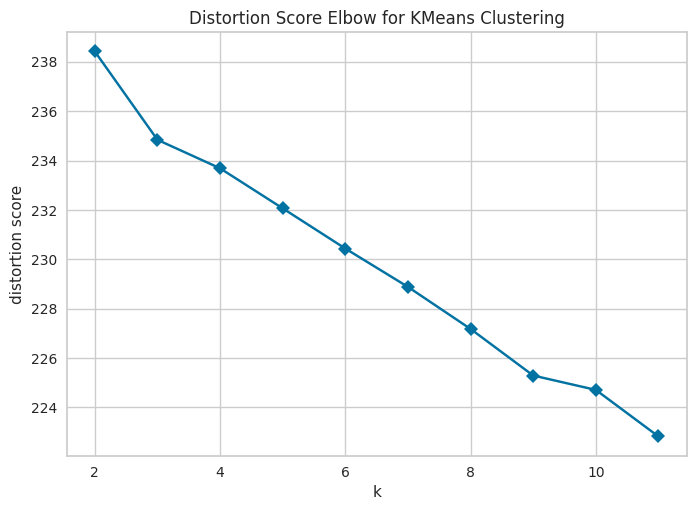

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
model = KMeans(random_state=42, n_init=10)

visualizer = KElbowVisualizer(
    model,
    k=(2, 12),
    metric='distortion',  # <--- Change metric to see if a peak appears
    timings=False
)

visualizer.fit(text_matrix.toarray())
visualizer.show()

Trying clustering with a few values of K

In [19]:
n_clusters_kmeans = 3

kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init=10)
labels = kmeans.fit_predict(text_matrix)

fair_use_findings['cluster_labels'] = labels.astype(str)

print(f"--- Cases per Cluster (K={n_clusters_kmeans}) ---")
print(fair_use_findings['cluster_labels'].value_counts())

print("\n--- Top Terms per Cluster ---")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

for i in range(n_clusters_kmeans):
    top_words = [terms[ind] for ind in order_centroids[i, :15]]
    print(f"Cluster {i}: {', '.join(top_words)}")

--- Cases per Cluster (K=3) ---
cluster_labels
2    146
1     70
0     35
Name: count, dtype: int64

--- Top Terms per Cluster ---
Cluster 0: photograph, post, factor, article, work, photographs, photo, defendants, purpose, image, instagram, violent, hues, violent hues, rnc
Cluster 1: defendants, plaintiffs, work, song, articles, factor, unpublished, works, video, parody, market, held, book, advertisement, used
Cluster 2: works, work, factor, photographs, plaintiffs, held, market, copying, news, images, did, purpose, copyrighted, film, used


In [23]:
n_clusters_kmeans = 5

kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init=10)
labels = kmeans.fit_predict(text_matrix)

fair_use_findings['cluster_labels'] = labels.astype(str)

print(f"--- Cases per Cluster (K={n_clusters_kmeans}) ---")
print(fair_use_findings['cluster_labels'].value_counts())

print("\n--- Top Terms per Cluster ---")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

for i in range(n_clusters_kmeans):
    top_words = [terms[ind] for ind in order_centroids[i, :15]]
    print(f"Cluster {i}: {', '.join(top_words)}")

--- Cases per Cluster (K=5) ---
cluster_labels
1    90
4    83
2    31
3    28
0    19
Name: count, dtype: int64

--- Top Terms per Cluster ---
Cluster 0: advertisement, television, advertisements, booklet, defendants, tveyes, articles, poster, campaign, advertising, series, work, montage, comics, rocky
Cluster 1: plaintiffs, defendants, works, factor, film, copies, held, video, software, work, copying, did, news, song, market
Cluster 2: photograph, article, post, factor, work, photo, defendants, image, original, violent, violent hues, hues, purpose, blog, weighed
Cluster 3: photographs, images, photos, works, work, factor, sculpture, photograph, transformative, search, gossip, website, artwork, hustler, cmg
Cluster 4: defendants, work, factor, book, parody, song, market, works, favor, used, weighed, biography, material, finding, video


Sticking to K = 5 because it seems more relevant k =3 creates blobs

/tmp/ipython-input-3092478984.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=fair_use_findings, x='cluster_labels', y='doc_length', palette='Set2')


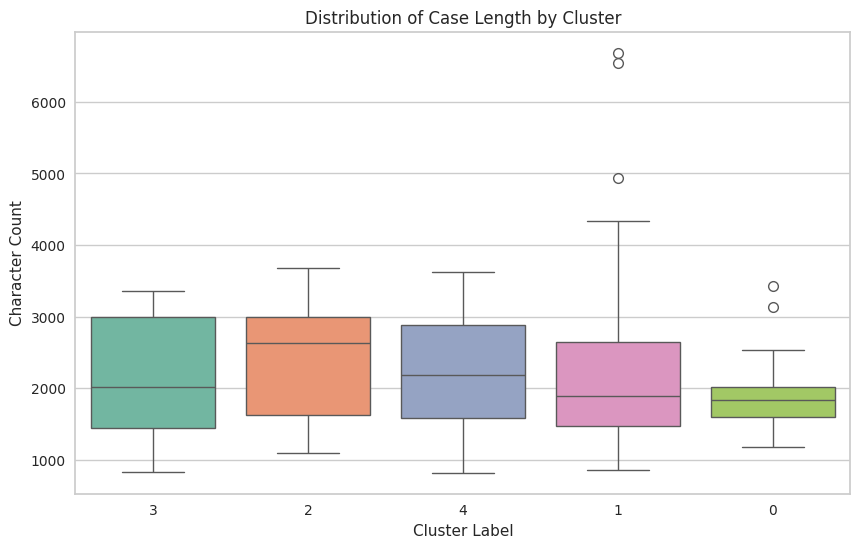

In [24]:
fair_use_findings['doc_length'] = fair_use_findings['full_text'].apply(len)

# 3. Plot: Text Length by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=fair_use_findings, x='cluster_labels', y='doc_length', palette='Set2')
plt.title('Distribution of Case Length by Cluster')
plt.ylabel('Character Count')
plt.xlabel('Cluster Label')
plt.show()

Trying a Hiearchial clustering to validate finding

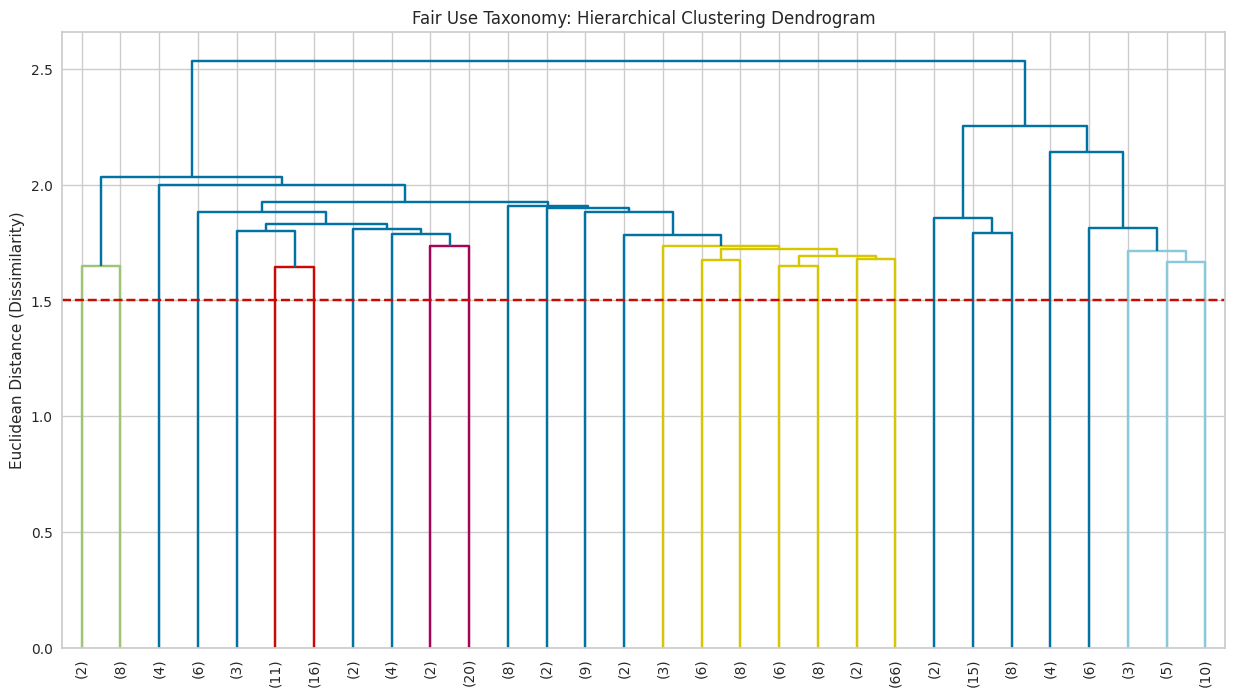

In [26]:
linkage_matrix = shc.linkage(text_matrix.toarray(), method='ward')

# 2. Plot the Dendrogram
plt.figure(figsize=(15, 8))
plt.title("Fair Use Taxonomy: Hierarchical Clustering Dendrogram")

# This plots the tree
dend = shc.dendrogram(
    linkage_matrix,
    labels=fair_use_findings['cluster_labels'].values, # Label points with their K-Means cluster to see overlap
    leaf_rotation=90,
    leaf_font_size=10,
    truncate_mode='lastp',  # Show only the last 'p' merged clusters to keep it readable
    p=30                    # Show top 30 branches
)

plt.ylabel("Euclidean Distance (Dissimilarity)")
plt.axhline(y=1.5, color='r', linestyle='--') # Add a cut line (adjust y based on plot)
plt.show()